In [1]:
import os
import sys
import gc
import ast
import cv2
import time
import timm
import pickle
import random
import argparse
import warnings
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda')
torch.backends.cudnn.benchmark = True


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
image_size = 224
n_slice_per_c = 12    # number of slices for each instance
in_chans = 3      # number of channels in input to CNN
backbone = 'legacy_seresnet50'
 
init_lr = 3e-4
eta_min = 3e-5
batch_size = 16 
drop_rate = 0.2
drop_rate_last = 0.3
drop_path_rate = 0.
p_mixup = 0.5
p_rand_order_v1 = 0.2    #probabilty of random arrangement of images

data_dir = '../input/rsna-cropped-2d-224-0920-2m/cropped_2d_224_15_ext0_5ch_0920_2m/cropped_2d_224_15_ext0_5ch_0920_2m'
use_amp = True
num_workers = 2
out_dim = 3           # number of output classes

n_epochs = 25

# log_dir = './logs'
# model_dir = './models'
# os.makedirs(log_dir, exist_ok=True)
# os.makedirs(model_dir, exist_ok=True)

In [3]:
print(n_epochs)

25


In [4]:
transforms_train = albumentations.Compose([
    albumentations.Crop(x_min=0, y_min=56, x_max=400, y_max=456,always_apply=True),
    albumentations.Resize(224, 224),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.Transpose(p=0.5),
    albumentations.RandomBrightness(limit=0.1, p=0.7),
    albumentations.ShiftScaleRotate(shift_limit=0.3, scale_limit=0.3, rotate_limit=45, border_mode=4, p=0.7),

    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=3),
        albumentations.MedianBlur(blur_limit=3),
        albumentations.GaussianBlur(blur_limit=3),
        albumentations.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.5),
    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=1.),
        albumentations.GridDistortion(num_steps=5, distort_limit=1.),
    ], p=0.5),

    albumentations.Cutout(max_h_size=int(224 * 0.5), max_w_size=int(224 * 0.5), num_holes=1, p=0.5),
])

transforms_valid = albumentations.Compose([
    albumentations.Crop(x_min=0, y_min=56, x_max=400, y_max=456,always_apply=True),
    albumentations.Resize(224, 224),
])


/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/blur/transforms.py:184: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [5]:
train_df = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv')
with open('/kaggle/input/liver-train-images/conv_range.pkl', 'rb') as f:
    conv_range = pickle.load(f)

In [6]:
train_df['liver_det'] = False
for item in tqdm(conv_range):
    train_df.loc[train_df['patient_id']==int(item),['liver_det']] = True

100%|██████████| 2717/2717 [00:03<00:00, 902.32it/s]


In [7]:
train_df = train_df[train_df['liver_det']==True]

In [8]:
train_df1 = train_df[train_df['liver_healthy'] == 0][:250]
test_df1 = train_df[train_df['liver_healthy'] == 0][250:]

In [9]:
train_df2 = train_df[train_df['liver_healthy'] == 1][:750]
test_df2 = train_df[train_df['liver_healthy'] == 1][750:900]

In [10]:
train_df = pd.concat([train_df1,train_df2])
valid_df = pd.concat([test_df1,test_df2])

In [11]:
valid_df = valid_df.drop([1017])

In [12]:
train_dict= {}
for name in tqdm(os.listdir('/kaggle/input/liver-train-images/output/')):
    paths = [f'/kaggle/input/liver-train-images/output/{name}/{item}.png' for item in range(0, 60)]
    train_dict[int(name)] = paths

100%|██████████| 2717/2717 [00:00<00:00, 55130.81it/s]


In [13]:
def select_elements_with_spacing(input_list):
    
    selected_indices = []
        
    selected_indices = [i for i in range(2,58,5)]
    
    selected_elements = [input_list[index] for index in selected_indices]
    
    return selected_elements


In [14]:
def preprocess_jpeg(jpeg_path):
    
    img = cv2.imread(jpeg_path)
    greyscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    return greyscale


In [15]:
img1 = preprocess_jpeg(f'/kaggle/input/liver-train-images/output/10004/0.png')
img2 = preprocess_jpeg(f'/kaggle/input/liver-train-images/output/10004/1.png')
img3 = preprocess_jpeg(f'/kaggle/input/liver-train-images/output/10004/2.png')
image = np.asarray([img1,img2,img3]).transpose(1, 2, 0)
img = transforms_train(image=image)['image']
img.shape

(224, 224, 3)

In [16]:
class CLSDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
#         row = self.df.iloc[index]
#         cid = row.c
        patient_id = self.df['patient_id'][index]
        images = []
        for ind in list(range(2,58,5)):
            img1 = preprocess_jpeg(f'/kaggle/input/liver-train-images/output/{patient_id}/{ind-1}.png')
            img2 = preprocess_jpeg(f'/kaggle/input/liver-train-images/output/{patient_id}/{ind}.png')
            img3 = preprocess_jpeg(f'/kaggle/input/liver-train-images/output/{patient_id}/{ind+1}.png')
            image = np.asarray([img1,img2,img3]).transpose(1, 2, 0)
            image = self.transform(image=image)['image']
            image = image.transpose(2, 0, 1).astype(np.float32) / 255.
            images.append(image)
        images = np.stack(images, 0)
#         print(images.shape)
        
        label = self.df[self.df.patient_id == int(patient_id)].values[0][1:-1]
        liver = np.argmax(label[7:10], keepdims = False)

        if self.mode != 'test':
            images = torch.tensor(images).float()
#             labels = torch.tensor([liver] * n_slice_per_c).float()
            labels = torch.tensor([liver] * n_slice_per_c)
            
            if self.mode == 'train' and random.random() < p_rand_order_v1:
                indices = torch.randperm(images.size(0))
                images = images[indices]

            return images, labels
        else:
            return torch.tensor(images).float()


m = timm.create_model(
            "resnet50d",
            in_chans=in_chans,
            num_classes=out_dim,
            features_only=False,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=False
        )
m

m = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_dim,
            features_only=False,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=False
        )
m

m = timm.create_model(
            "legacy_seresnet50",
            in_chans=in_chans,
            num_classes=out_dim,
            features_only=False,
            drop_rate=drop_rate,
            pretrained=False
        )
m

In [17]:
class TimmModel(nn.Module):
    def __init__(self, backbone, pretrained=False):
        super(TimmModel, self).__init__()

        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_dim,
            features_only=False,
            drop_rate=drop_rate,
            pretrained=pretrained
        )
        
        
        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'resnet' in backbone:
            hdim = 2048
            self.encoder.last_linear = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()
        self.lstm = nn.LSTM(hdim, 256, num_layers=2, dropout=drop_rate, bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.Dropout(drop_rate_last),
            nn.LeakyReLU(0.1),
            nn.Linear(256, out_dim),
        )
    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        x = x.view(bs * n_slice_per_c, in_chans, image_size, image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, n_slice_per_c, -1)
        feat, _ = self.lstm(feat)
        feat = feat.contiguous().view(bs * n_slice_per_c, -1)
        feat = self.head(feat)
        feat = feat.view(bs, n_slice_per_c,-1).contiguous()

        return feat

In [18]:
m = TimmModel(backbone)
out = m(torch.rand(2, n_slice_per_c, in_chans, image_size, image_size))
out.shape

torch.Size([2, 12, 3])

In [19]:
# bce = nn.BCEWithLogitsLoss(reduction='none')
cce = nn.CrossEntropyLoss(label_smoothing = 0.05, weight = torch.tensor([1.0, 2.0, 4.0]).to('cuda'))


def criterion(logits, targets, activated=False):
    if activated:
        losses = nn.BCELoss(reduction='none')(logits.view(-1), targets.view(-1))
    else:
        losses = cce(logits.view(-1,3), targets.view(-1))
#     losses[targets.view(-1) > 0] *= 2.
#     norm = torch.ones(logits.view(-1).shape[0]).to(device)
#     norm[targets.view(-1) > 0] *= 2
    return losses


In [20]:
def mixup(input, truth, clip=[0, 1]):
    indices = torch.randperm(input.size(0))
    shuffled_input = input[indices]
    shuffled_labels = truth[indices]

    lam = np.random.uniform(clip[0], clip[1])
    input = input * lam + shuffled_input * (1 - lam)
    return input, truth, shuffled_labels, lam
def train_func(model, loader_train, optimizer, scaler=None):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, targets in bar:
        optimizer.zero_grad()
        images = images.cuda()
        targets = targets.cuda()
        
        do_mixup = False
        if random.random() < p_mixup:
            do_mixup = True
            images, targets, targets_mix, lam = mixup(images, targets)

        with amp.autocast():
            logits = model(images)
            loss = criterion(logits, targets)
            if do_mixup:
                loss11 = criterion(logits, targets_mix)
                loss = loss * lam  + loss11 * (1 - lam)
        train_loss.append(loss.item())
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        bar.set_description(f'smth:{np.mean(train_loss[-30:]):.4f}')

    return np.mean(train_loss)

def valid_func(model, loader_valid):
    model.eval()
    valid_loss = []
    gts = []
    outputs = []
    bar = tqdm(loader_valid)
    tot_loss = 0
    with torch.no_grad():
        for images, targets in bar:
            images = images.cuda()
            targets = targets.cuda()

            logits = model(images)
            loss = criterion(logits, targets)
            
            gts.append(targets.cpu())
            outputs.append(logits.cpu())
            valid_loss.append(loss.item())
            tot_loss += loss.item()
            
            bar.set_description(f'smth:{np.mean(valid_loss[-30:]):.4f}')

    outputs = torch.cat(outputs)
    gts = torch.cat(gts)
#     valid_loss = criterion(outputs, gts).item()

    return np.mean(valid_loss)

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://githu

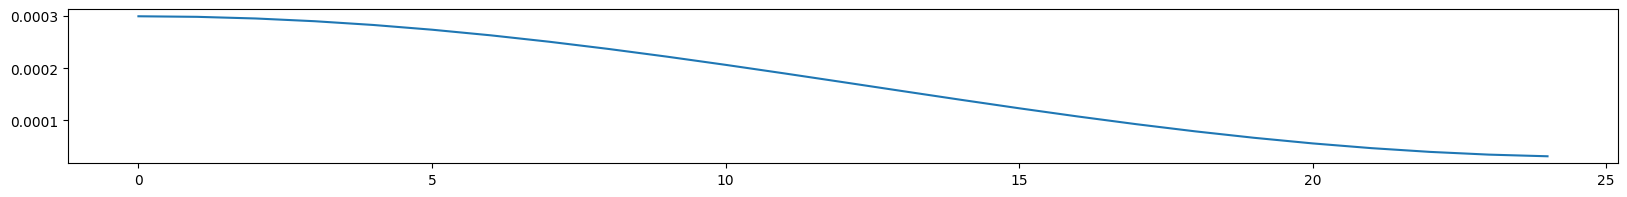

In [21]:
rcParams['figure.figsize'] = 20, 2
optimizer = optim.AdamW(m.parameters(), lr=init_lr)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs, eta_min=eta_min)

lrs = []
for epoch in range(1, n_epochs+1):
    scheduler_cosine.step(epoch-1)
    lrs.append(optimizer.param_groups[0]["lr"])
plt.plot(range(len(lrs)), lrs)

In [22]:
train_df = train_df.drop(['liver_det'],axis=1)
valid_df = valid_df.drop(['liver_det'],axis=1)

In [23]:
dataset_train = CLSDataset(train_df, 'train', transform=transforms_train)
dataset_valid = CLSDataset(valid_df, 'valid', transform=transforms_valid)
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=num_workers)

model = TimmModel(backbone, pretrained=True)
model = model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=init_lr)
scaler = torch.cuda.amp.GradScaler() if use_amp else None

metric_best = np.inf
loss_min = np.inf

scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs, eta_min=eta_min)

print(len(dataset_train), len(dataset_valid))

for epoch in range(1, n_epochs+1):
    scheduler_cosine.step(epoch-1)

    print(time.ctime(), 'Epoch:', epoch)

    train_loss = train_func(model, loader_train, optimizer, scaler)
    valid_loss = valid_func(model, loader_valid)
    metric = valid_loss

    content = time.ctime() + ' ' + f' Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
    print(content)

    if metric < metric_best:
        print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
#             if not DEBUG:
        torch.save(model.state_dict(), 'best_model.pth')
        metric_best = metric
    torch.cuda.empty_cache()
    # Save Last
    if(epoch%6==0):
        torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_state_dict': scaler.state_dict() if scaler else None,
            'score_best': metric_best,
        },
        f'checkpoint_{epoch}.pth'
    )
    torch.save(
        {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scaler_state_dict': scaler.state_dict() if scaler else None,
            'score_best': metric_best,
        },
        'last_epoch.pth'
    )


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/se_resnet50-ce0d4300.pth" to /root/.cache/torch/hub/checkpoints/se_resnet50-ce0d4300.pth


1000 199
Wed Oct  4 13:09:59 2023 Epoch: 1


smth:1.1130: 100%|██████████| 13/13 [00:45<00:00,  3.50s/it]


Wed Oct  4 13:15:11 2023  Epoch 1, lr: 0.0003000, train loss: 1.09651, valid loss: 1.11304, metric: 1.113042.
metric_best (inf --> 1.113042). Saving model ...
Wed Oct  4 13:15:11 2023 Epoch: 2


smth:0.8871: 100%|██████████| 13/13 [00:24<00:00,  1.87s/it]


Wed Oct  4 13:18:22 2023  Epoch 2, lr: 0.0002989, train loss: 1.05081, valid loss: 0.88713, metric: 0.887134.
metric_best (1.113042 --> 0.887134). Saving model ...
Wed Oct  4 13:18:24 2023 Epoch: 3


smth:0.8683: 100%|██████████| 13/13 [00:24<00:00,  1.89s/it]


Wed Oct  4 13:21:27 2023  Epoch 3, lr: 0.0002958, train loss: 1.02610, valid loss: 0.86835, metric: 0.868347.
metric_best (0.887134 --> 0.868347). Saving model ...
Wed Oct  4 13:21:29 2023 Epoch: 4


smth:1.1290: 100%|██████████| 13/13 [00:24<00:00,  1.89s/it]


Wed Oct  4 13:24:33 2023  Epoch 4, lr: 0.0002905, train loss: 1.00380, valid loss: 1.12899, metric: 1.128993.
Wed Oct  4 13:24:34 2023 Epoch: 5


smth:0.9901: 100%|██████████| 13/13 [00:26<00:00,  2.01s/it]


Wed Oct  4 13:27:44 2023  Epoch 5, lr: 0.0002833, train loss: 1.00815, valid loss: 0.99012, metric: 0.990122.
Wed Oct  4 13:27:46 2023 Epoch: 6


smth:0.8431: 100%|██████████| 13/13 [00:25<00:00,  1.98s/it]


Wed Oct  4 13:30:54 2023  Epoch 6, lr: 0.0002742, train loss: 0.97509, valid loss: 0.84311, metric: 0.843113.
metric_best (0.868347 --> 0.843113). Saving model ...
Wed Oct  4 13:30:56 2023 Epoch: 7


smth:1.1161: 100%|██████████| 13/13 [00:27<00:00,  2.11s/it]


Wed Oct  4 13:34:09 2023  Epoch 7, lr: 0.0002634, train loss: 0.99496, valid loss: 1.11609, metric: 1.116091.
Wed Oct  4 13:34:11 2023 Epoch: 8


smth:1.1070: 100%|██████████| 13/13 [00:24<00:00,  1.91s/it]


Wed Oct  4 13:37:19 2023  Epoch 8, lr: 0.0002511, train loss: 0.96993, valid loss: 1.10702, metric: 1.107023.
Wed Oct  4 13:37:20 2023 Epoch: 9


smth:1.8502: 100%|██████████| 13/13 [00:26<00:00,  2.01s/it]


Wed Oct  4 13:40:31 2023  Epoch 9, lr: 0.0002373, train loss: 0.95881, valid loss: 1.85020, metric: 1.850196.
Wed Oct  4 13:40:32 2023 Epoch: 10


smth:0.8291: 100%|██████████| 13/13 [00:24<00:00,  1.89s/it]


Wed Oct  4 13:43:40 2023  Epoch 10, lr: 0.0002225, train loss: 0.97047, valid loss: 0.82910, metric: 0.829104.
metric_best (0.843113 --> 0.829104). Saving model ...
Wed Oct  4 13:43:42 2023 Epoch: 11


smth:1.0010: 100%|██████████| 13/13 [00:25<00:00,  1.94s/it]


Wed Oct  4 13:46:46 2023  Epoch 11, lr: 0.0002067, train loss: 0.95302, valid loss: 1.00104, metric: 1.001036.
Wed Oct  4 13:46:48 2023 Epoch: 12


smth:0.7964: 100%|██████████| 13/13 [00:23<00:00,  1.82s/it]


Wed Oct  4 13:49:51 2023  Epoch 12, lr: 0.0001903, train loss: 0.93664, valid loss: 0.79642, metric: 0.796419.
metric_best (0.829104 --> 0.796419). Saving model ...
Wed Oct  4 13:49:53 2023 Epoch: 13


smth:0.8509: 100%|██████████| 13/13 [00:25<00:00,  1.94s/it]


Wed Oct  4 13:52:58 2023  Epoch 13, lr: 0.0001735, train loss: 0.92494, valid loss: 0.85085, metric: 0.850851.
Wed Oct  4 13:52:59 2023 Epoch: 14


smth:0.8522: 100%|██████████| 13/13 [00:25<00:00,  1.95s/it]


Wed Oct  4 13:56:04 2023  Epoch 14, lr: 0.0001565, train loss: 0.91370, valid loss: 0.85222, metric: 0.852225.
Wed Oct  4 13:56:05 2023 Epoch: 15


smth:0.7772: 100%|██████████| 13/13 [00:24<00:00,  1.89s/it]


Wed Oct  4 13:59:09 2023  Epoch 15, lr: 0.0001397, train loss: 0.90395, valid loss: 0.77724, metric: 0.777237.
metric_best (0.796419 --> 0.777237). Saving model ...
Wed Oct  4 13:59:11 2023 Epoch: 16


smth:0.7579: 100%|██████████| 13/13 [00:24<00:00,  1.88s/it]


Wed Oct  4 14:02:17 2023  Epoch 16, lr: 0.0001233, train loss: 0.88228, valid loss: 0.75795, metric: 0.757946.
metric_best (0.777237 --> 0.757946). Saving model ...
Wed Oct  4 14:02:19 2023 Epoch: 17


smth:0.7598: 100%|██████████| 13/13 [00:24<00:00,  1.89s/it]


Wed Oct  4 14:05:22 2023  Epoch 17, lr: 0.0001075, train loss: 0.85771, valid loss: 0.75976, metric: 0.759755.
Wed Oct  4 14:05:24 2023 Epoch: 18


smth:0.7919: 100%|██████████| 13/13 [00:24<00:00,  1.86s/it]


Wed Oct  4 14:08:28 2023  Epoch 18, lr: 0.0000927, train loss: 0.90724, valid loss: 0.79191, metric: 0.791906.
Wed Oct  4 14:08:30 2023 Epoch: 19


smth:0.7527: 100%|██████████| 13/13 [00:24<00:00,  1.90s/it]


Wed Oct  4 14:11:36 2023  Epoch 19, lr: 0.0000789, train loss: 0.83099, valid loss: 0.75274, metric: 0.752739.
metric_best (0.757946 --> 0.752739). Saving model ...
Wed Oct  4 14:11:38 2023 Epoch: 20


smth:0.7421: 100%|██████████| 13/13 [00:25<00:00,  1.93s/it]


Wed Oct  4 14:14:44 2023  Epoch 20, lr: 0.0000666, train loss: 0.86914, valid loss: 0.74209, metric: 0.742092.
metric_best (0.752739 --> 0.742092). Saving model ...
Wed Oct  4 14:14:46 2023 Epoch: 21


smth:0.7769: 100%|██████████| 13/13 [00:25<00:00,  1.93s/it]


Wed Oct  4 14:17:53 2023  Epoch 21, lr: 0.0000558, train loss: 0.83871, valid loss: 0.77689, metric: 0.776887.
Wed Oct  4 14:17:55 2023 Epoch: 22


smth:0.7524: 100%|██████████| 13/13 [00:24<00:00,  1.91s/it]


Wed Oct  4 14:21:00 2023  Epoch 22, lr: 0.0000467, train loss: 0.82958, valid loss: 0.75244, metric: 0.752442.
Wed Oct  4 14:21:01 2023 Epoch: 23


smth:0.8764: 100%|██████████| 13/13 [00:24<00:00,  1.90s/it]


Wed Oct  4 14:24:05 2023  Epoch 23, lr: 0.0000395, train loss: 0.82560, valid loss: 0.87638, metric: 0.876376.
Wed Oct  4 14:24:06 2023 Epoch: 24


smth:0.7686: 100%|██████████| 13/13 [00:24<00:00,  1.89s/it]


Wed Oct  4 14:27:10 2023  Epoch 24, lr: 0.0000342, train loss: 0.80058, valid loss: 0.76860, metric: 0.768597.
Wed Oct  4 14:27:12 2023 Epoch: 25


smth:0.7986: 100%|██████████| 13/13 [00:24<00:00,  1.88s/it]


Wed Oct  4 14:30:17 2023  Epoch 25, lr: 0.0000311, train loss: 0.79090, valid loss: 0.79862, metric: 0.798619.


In [24]:
torch.cuda.empty_cache()